In [2]:
# Imports
import os
import pandas as pd
from dask import dataframe as dd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as dt
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib as mpl
plt.style.use("dark_paper")
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = r'\usepackage[cm]{sfmath}'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'cm'

In [68]:
total_usage = pd.read_parquet('total_usage.gzip')
total_acorn= pd.read_parquet('total_acorn.gzip')
groups= pd.read_parquet('groups.gzip')
# total_acorn.acorn_group.nunique() == 19
# total_acorn.acorn_group.unique()
# """    'ACORN-A', 'ACORN-P', 'ACORN-E', 'ACORN-Q', 'ACORN-H', 'ACORN-L',
#        'ACORN-N', 'ACORN-K', 'ACORN-J', 'ACORN-U', 'ACORN-D', 'ACORN-F',
#        'ACORN-G', 'ACORN-C', 'ACORN-M', 'ACORN-O', 'ACORN-I', 'ACORN-B',
#        'ACORN-'
# """
# groups = total_acorn.groupby(['acorn_category', 'house_id']).count()

In [69]:
#TODO:
# Check if effect of intervention persists after 2013
# Investigate early lower consumption
# Introduce tariffs in the model
# T-test for each hour of the day tariff vs. no tariff (same group) / tariff vs. control / tariff vs. both / intervention vs control
# Instead of normalizing look at the diff for pricing
# Look at tariff hour distribution

# redo analyses
# Look at prices
# Make class models

In [82]:
# from functools import reduce
# from operator import and_
# def agg(df, **kwargs):
#     mask = reduce(and_, (df[name]==value for name, value in kwargs.items()))
#     return df[mask]

def tostring(item):
    name, value = item
    if type(value) == str:
        expr = f"({name}=='{value}')"
    else:
        expr = f"({name}=={value})"
    return expr

def agg(df, **kwargs):
    expression = "&".join([tostring(item) for item in kwargs.items()])
    return df.query(expression)

def idx2time(series):
    return pd.to_datetime(['-'.join(map(str,x)) for x in series.index], format="%Y-%m-%d-%H")
def arrays(series):
    x = idx2time(series).values
    y = series.values
    return (x,y)

In [75]:
# TODO:
# Predict house specific consumption using data from other house
# Long vs short term predictions?
# Multiple hypothesis testing
# Modeling
# Normalize for different behaviours across homes
# visualize the difference in consmption for different homes
# Look at the difference

# affluent = total_acorn.house_id[total_acorn.acorn_category=='Affluent'].unique()
# adversity = total_acorn.house_id[total_acorn.acorn_category=='Adversity'].unique()
# comfortable = total_acorn.house_id[total_acorn.acorn_category=='Comfortable'].unique()

In [72]:
# gethousehold ids. 
affluent = groups.loc['Affluent'].index.values
comfortable = groups.loc['Comfortable'].index.values
adversity = groups.loc['Adversity'].index.values

In [73]:
def get_data(group, treated, hourly=False):
    subset = total_usage[:]
    subset = subset[subset.house_id.isin(group)]
    df_agg = agg(subset, treated=treated)
    if hourly:
        series = df_agg.groupby([df_agg.date_time.dt.year, df_agg.date_time.dt.month, 
                                 df_agg.date_time.dt.day, df_agg.date_time.dt.hour])['KWH/hh'].mean()
    else:
        series = df_agg.groupby([df_agg.date_time.dt.year, df_agg.date_time.dt.month, 
                                 df_agg.date_time.dt.day])['KWH/hh'].mean()
    return arrays(series)

In [83]:
%%time
xyaff = get_data(affluent, treated=True, hourly=True)
xyaff0 = get_data(affluent, treated=False, hourly=True)

CPU times: user 36.5 s, sys: 1min 59s, total: 2min 35s
Wall time: 3min


In [84]:
%%time
xycomf = get_data(comfortable, treated=True, hourly=True)
xycomf0 = get_data(comfortable, treated=False, hourly=True)
xyadv = get_data(adversity, treated=True, hourly=True)
xyadv0 = get_data(adversity, treated=False, hourly=True)

CPU times: user 1min 3s, sys: 3min 6s, total: 4min 10s
Wall time: 4min 42s


In [85]:
def save_data(xy, key, file="consumption.h5"):
    pd.Series(xy[1], xy[0]).to_hdf(file, key=key, complevel=9)

In [86]:
keys =['adversity', 'adversity0', 'comfortable', 'comfortable0', 'affluent', 'affluent0']
for xy, key in zip([xyadv, xyadv0, xycomf, xycomf0, xyaff, xyaff0], keys):
    save_data(xy, key, file="averaged_hourly.h5")

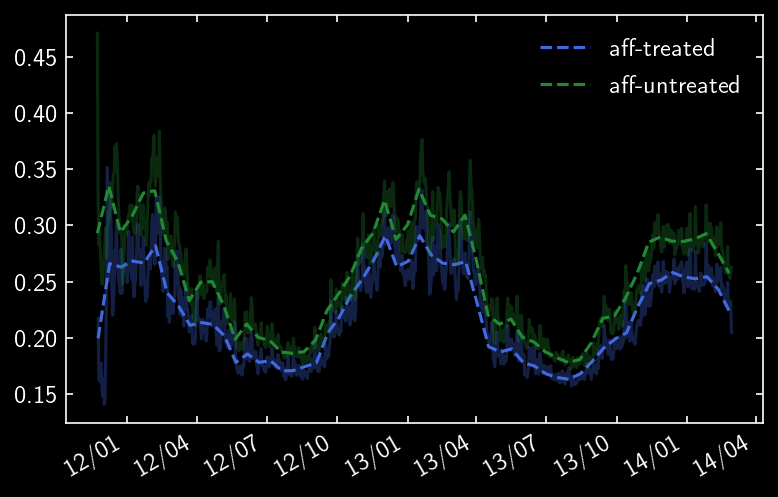

CPU times: user 740 ms, sys: 881 ms, total: 1.62 s
Wall time: 3.35 s


In [162]:
%%time
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=150)
plot_line(xyaff, ax, label='aff-treated', c='C0', alpha=.3)
plot_line(xyaff0, ax, label='aff-untreated', c='C1', alpha=.3)
# Set the x-axis to do major ticks on the days and label them like '07/20'
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%y/%m'))
ax.legend()
plt.show()

In [63]:
def plot_line(xy, ax=None, label=None, c=None, alpha=.5):
    time, data = xy
    if ax is not None:
        ax.plot(time,data, alpha=alpha, c=c)
    else:
        plt.plot(time,data, alpha=alpha, c=c)
    pd.Series(data,index=time).resample('15D').mean().plot(ax=ax, ls='--', label=label, c=c)

NameError: name 'plot_line' is not defined

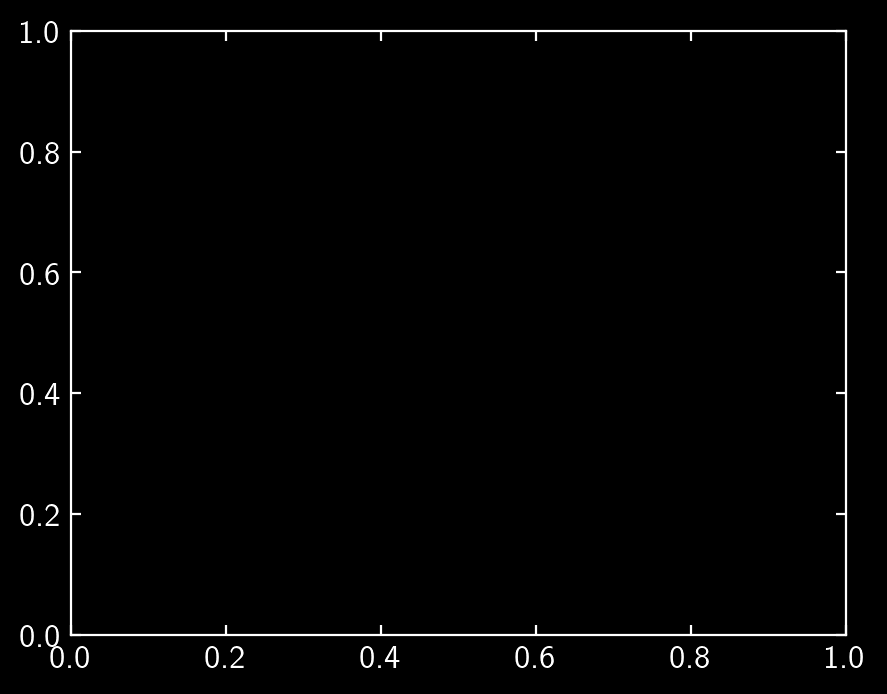

In [87]:
%%time
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
plot_line(xyaff, ax, label='aff-treated', c='C0', alpha=.3)
plot_line(xycomf, ax, label='comf-treated', c='C1', alpha=.3)
plot_line(xyadv, ax, label='adv-treated', c='C2', alpha=.3)
# Set the x-axis to do major ticks on the days and label them like '07/20'
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%y/%m'))
ax.legend()
plt.show()

# Tariffs, temperatures, and more

In [18]:
tar = pd.read_csv('data/Tariffs.csv')
tar.index = pd.to_datetime(tar['TariffDateTime'])
tar = tar['Tariff']
tar = tar.replace({"Low":0, "Normal":1, "High":2}).astype('int16')

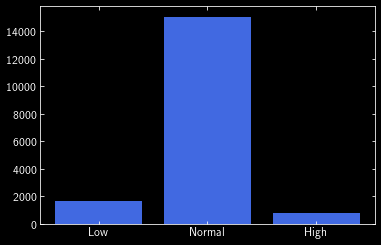

In [19]:
x, height = np.unique(tar.values, return_counts=True)
plt.bar(x, height)
plt.xticks(x, labels=['Low', 'Normal', 'High'])
plt.show()

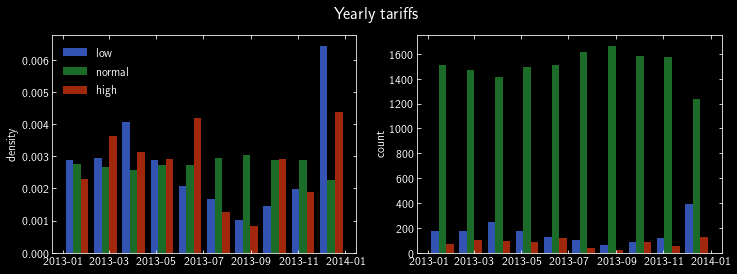

In [58]:
#year
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4))
ax.hist([tar[tar == i].index.values for i in range(3)], alpha=.8, density=True, 
         bins=10, label=['low', 'normal', 'high'])
ax.legend()
ax.set_ylabel('density')
ax1.hist([tar[tar == i].index.values for i in range(3)], alpha=.8, density=False, 
         bins=10, label=['low', 'normal', 'high'])
ax1.set_ylabel('count')
fig.suptitle('Yearly tariffs')
plt.show()

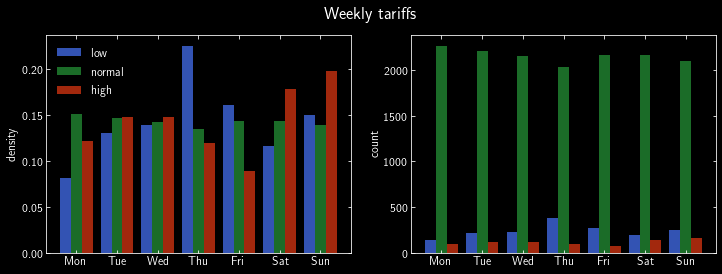

In [57]:
#month
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4))
bins=np.arange(8)
ax.hist([tar[tar == i].index.to_series().dt.dayofweek for i in range(3)], alpha=.8, density=True, 
         bins=bins, label=['low', 'normal', 'high'])
ax.legend()
ax.set_ylabel('density')
ax1.hist([tar[tar == i].index.to_series().dt.dayofweek for i in range(3)], alpha=.8, density=False, 
         bins=bins, label=['low', 'normal', 'high'])
ax1.set_ylabel('count')

for ax in [ax, ax1]:
    ax.set_xticks(np.arange(7)+0.5)
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

fig.suptitle('Weekly tariffs')
plt.show()

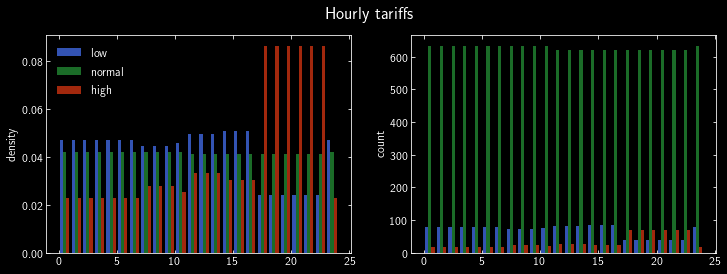

In [55]:
#day
fig, (ax, ax1) = plt.subplots(1,2, figsize=(12,4))
bins=np.arange(25)
ax.hist([tar[tar == i].index.to_series().dt.hour for i in range(3)], alpha=.8, density=True, 
         bins=bins, label=['low', 'normal', 'high'])
ax.legend()
ax.set_ylabel('density')
ax1.hist([tar[tar == i].index.to_series().dt.hour for i in range(3)], alpha=.8, density=False, 
         bins=bins, label=['low', 'normal', 'high'])
ax1.set_ylabel('count')
fig.suptitle('Hourly tariffs')
plt.show()

In [11]:
dtemp = pd.read_csv('data/weather/midas-open_uk-daily-temperature-obs_dv-202007_greater-london_00697_london-st-jamess-park_qcv-1_2012.csv',
                skiprows=90)
dtemp = dtemp[:-1]
dtemp.index = pd.to_datetime(dtemp['ob_end_time'])
dtemp = dtemp[['min_air_temp', 'max_air_temp']]

In [12]:
temp_list = []
for i in [2011,2012,2013,2014]:
    htemp = pd.read_csv(f'data/weather/midas-open_uk-hourly-weather-obs_dv-202007_greater-london_00697_london-st-jamess-park_qcv-1_{i}.csv',
                    skiprows=280)
    htemp = htemp[:-1]
    htemp.index = pd.to_datetime(htemp['ob_time'])
    htemp = htemp['air_temperature']
    temp_list.append(htemp)
temps = pd.concat(temp_list)
temps.to_hdf('temp.h5', 'data', complevel=9)

/home/kitouni/anaconda3/envs/gnn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (93) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


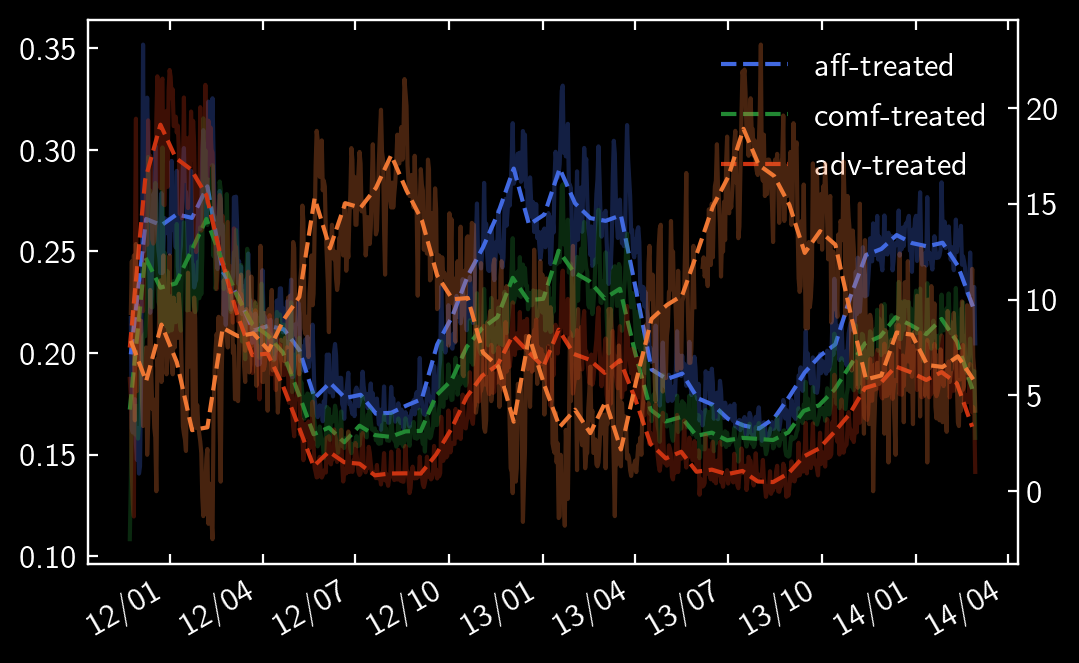

CPU times: user 458 ms, sys: 3.24 ms, total: 461 ms
Wall time: 459 ms


In [161]:
%%time
fig, ax = plt.subplots(1,1, figsize=(6,4), dpi=200)
ax2=ax.twinx()
plot_line((xyaff[0],temps[xyaff[0]].values), ax2, label='temp', c='C3', alpha=.3)
plot_line(xyaff, ax, label='aff-treated', c='C0', alpha=.3)
plot_line(xycomf, ax, label='comf-treated', c='C1', alpha=.3)
plot_line(xyadv, ax, label='adv-treated', c='C2', alpha=.3)
# Set the x-axis to do major ticks on the days and label them like '07/20'
ax.xaxis.set_major_locator(MonthLocator(interval=3))
ax.xaxis.set_major_formatter(DateFormatter('%y/%m'))
ax.legend()
plt.show()